# Importing Required Packages

In [1]:
# Load Packages
# Basic packages/visualization
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import pandas as pd
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import glob
#import gc
import random
from torchvision.transforms.functional import resize
import torch.nn.functional as F
import torchvision   
import scipy
from skimage import exposure

# Custom written .py files
from helper import ground_truth_files, back_images
#import segmentation_models_pytorch as smp
#import unet


In [2]:
# Deep Learning Packages
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import torch.nn.functional as F
from unet import UNet
torch.cuda.empty_cache()

from clubfoot_transforms import *
from pytorchclubfootdataset import *
from models import FCNmodel_3pool, FCNmodel_2pool
from helper import * #show_image_batch_model, show_single_image_model, save_image_batch_model, return_criterions
from loss_functions import *
from training import *

In [3]:
os.chdir('../')
os.getcwd()

'/home/pattondm/Documents/ClubfootProjectData'

In [4]:
base_dir = os.getcwd()

In [5]:
#os.chdir('/home/pattondm/Documents/ClubfootProjectData/Clubfoot')
print(os.getcwd())

/home/pattondm/Documents/ClubfootProjectData


# Data Visualization and Training/Validation Splits

__ground_truth_files(clubfoot_type, base_dir)__ <br>
__Inputs:__ 
- __clubfoot_type__- 'AP', 'LAT', or None - this indicates the type of radiographs you are loading for training. None loads all images <br>
- __base_dir__ - the directory with all of the input data with the labeled folders for Clubfoot and Non-clubfoot images <br>


__Output:__ 
- A dataframe with the paths for the images, labeled bones, and background segmentation masks<br>
- Note: If any of the images are missing either the labeled bone or background segmentation mask they will be printed in the output

In [6]:
# from helper import ground_truth_background, back_images
data = ground_truth_files(base_dir, None) # clubfoot_type = 'AP','LAT', None
print('Total # of radiographs inlcuded in this study: ', len(data))

/home/pattondm/Documents/ClubfootProjectData/Hindfoot_Valgus/103
LAT_FOOT_2398.nii
Total # of radiographs inlcuded in this study:  325


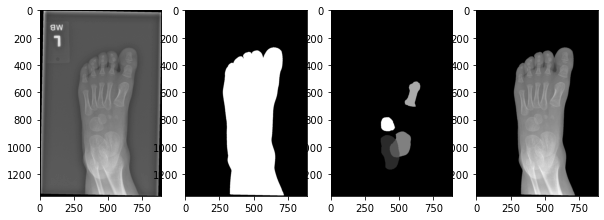

In [7]:
# Example input image, background mask, and mask overlay on input image
mask_images(data, 88)

In [8]:
# Splitting the data into the predetermined training and validation sets
split = pd.read_csv('Clubfoot_Update_012521.csv')

split['Folder ID'] = split['Folder ID'].astype(str)
data_2 = data.merge(split, left_on='folder', right_on='Folder ID', how='inner')
data_2 = data_2.drop(columns = ['Folder ID'])

training_data = data_2[data_2['Split'] == 'Training']
validation_data = data_2[data_2['Split'] == 'Validation']

# Clubfoot_Update_012521
print(' The training data size is: ', len(training_data),'\n',
      'The validation data size is: ', len(validation_data), '\n')

del data, data_2, split
#gc.collect()
#gc.collect();

 The training data size is:  186 
 The validation data size is:  36 



In [9]:
os.getcwd()

'/home/pattondm/Documents/ClubfootProjectData'

## Loading and Visualizing Training Data

In [10]:
##############################################################################
# Custom Augmentations for Bone Background Mask
##############################################################################
class ClaheFilter():
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        #print(image.min(), image.max())
        image_2 = image.copy()
        slope = 1/(image_2.max() - image_2.min())
        image_2 = np.subtract(image_2, image_2.min()) * slope
        image = image_2
        #print(image.min(), image.max(), image.shape, '\n')
        image_2 = exposure.equalize_adapthist(image, kernel_size=(25,25), clip_limit=0.01, nbins=256)
        return {'image': image_2.astype('float32'), 'mask' : mask}

class toTensorMask3():
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        
        preprocess = transforms.Compose([transforms.ToTensor()])
        image = preprocess(image.copy())
        mask = preprocess(mask.copy())
        mask = mask.permute(1,2,0)
        #print(mask.shape)
        return {'image': image, 'mask' : mask}

class LargeSizeCrop(object):
    """ Greyscale input image"""
    def __init__(self, factor):
        assert isinstance(factor, int)
        self.factor = factor
    
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        #print(image.size(), mask.size())
        h, w = image.shape[1:3]
        #print(h,w)
        down_sized = self.factor
        if h >=w:
            new_w = round((down_sized * w)/h)
            new_h = down_sized
        else:
            new_h = round((down_sized * h)/w)
            new_w = down_sized
            
        image = F.interpolate(image.unsqueeze(0), size=[new_h, new_w])#resize(image.unsqueeze(0), size = [new_h, new_w])
        mask = F.interpolate(mask.unsqueeze(0).float(), size = [new_h, new_w])
          
        return {'image': image.squeeze(0), 'mask' : mask.squeeze(0)}

    
class combinedPad():
    """ Greyscale input image"""
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        h, w = image.shape[1:3]
        if h>=w:
            size = h
        else:
            size = w
        if h >= w:
            h_pad_l, h_pad_r = 0, 0
            w_pad_l = round((h - w)/2)
            if ((w_pad_l * 2) + w) > size:
                w_pad_r = w_pad_l - 1
            if ((w_pad_l * 2) + w) < size:
                w_pad_r = w_pad_l + 1
            if ((w_pad_l * 2) + w) == size:
                w_pad_r = w_pad_l

        if w > h:
            w_pad_l, w_pad_r = 0, 0
            h_pad_l = round((w - h)/2)
            if ((h_pad_l * 2) + h) > size:
                h_pad_r = h_pad_l - 1
            if ((h_pad_l * 2) + h) < size:
                h_pad_r = h_pad_l + 1
            if ((h_pad_l * 2) + h) == size:
                h_pad_r = h_pad_l

        image = torch.nn.functional.pad(image, pad=(w_pad_l, w_pad_r, h_pad_l, h_pad_r))
        mask = torch.nn.functional.pad(mask,  pad= (w_pad_l, w_pad_r, h_pad_l, h_pad_r))
        #print(image.size(), mask.size())
        return {'image': image, 'mask' : mask}
    
class Normalize(object):
    """ Greyscale input image"""
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        m, s = image.mean().item(), image.std().item()
        image = (image - m)/s
        #epsilon = 1e-7
        return {'image': image, 'mask' : mask}


class RandomRotate(object):
    def __init__(self, probability):
        assert isinstance(probability, float)
        self.probability = probability
    
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        prob = self.probability
        num = int(1/prob)
        
        angle_counter = random.randint(0, num)
        if angle_counter == 0:
            #print('rotated')
            #print('Image shape is', image.shape, 'Mask shape is', mask.shape)
            angle = random.randint(0, 360)
            image = ndimage.rotate(image, angle, reshape=False)
            mask = ndimage.rotate(mask, angle, axes = (1, 2), reshape=False)
        
        return {'image': image, 'mask' : mask}
    
    
class RandomFlip(object):
    def __init__(self, probability):
        assert isinstance(probability, float)
        self.probability = probability
    
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        prob = self.probability
        num = int(1/prob)
        
        flip_counter = random.randint(0, num)
        if flip_counter == 0:
            #print('flipped')
            image = image[:,:-1]
            mask = mask[:,:,:-1]
            
        #print(image.shape, mask.shape)    
        return {'image': image, 'mask' : mask}

class RandomZoom(object):
    def __init__(self, probability):
        assert isinstance(probability, float)
        self.probability = probability
    
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        prob = self.probability
        num = int(1/prob)
        
        zoom_counter = random.randint(0, num)
        if zoom_counter == 0:
            #print('zoomed')
            scale_val = round(random.uniform(0.70, 1.5), 2)
            #print(image.shape, mask.shape)
            image = scipy.ndimage.zoom(image, zoom=scale_val)
            mask = scipy.ndimage.zoom(mask, zoom=(1, scale_val, scale_val))
        #print(image.shape, mask.shape)    
        return {'image': image, 'mask' : mask}
    
    
    
class grey_to_rgb(object):
    """ Greyscale input image"""
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        image = image.expand(3, -1, -1)
        return {'image': image, 'mask' : mask}
    
transformations = [ClaheFilter(),
                   RandomRotate(0.5),
                   RandomFlip(0.5),
                   RandomZoom(0.5),
                   toTensorMask3(),
                   LargeSizeCrop(400),
                   combinedPad(),
                   Normalize(),
                   #grey_to_rgb()
                 ]

training_dataset = ClubfootDataset(df = training_data, group = 'both', bone = 'Multi',
                                    transform=transforms.Compose(transformations)
                                  )
training_dataloader = DataLoader(training_dataset, batch_size=8,
                        shuffle=True, num_workers=0)

validation_dataset = ClubfootDataset(df = validation_data, group = 'both', bone = 'Multi',
                                    transform=transforms.Compose(transformations)
                                  )
validation_dataloader = DataLoader(validation_dataset, batch_size=8,
                        shuffle=True, num_workers=0)

0 torch.Size([8, 1, 400, 400]) torch.Size([8, 5, 400, 400])


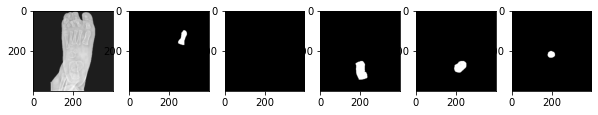

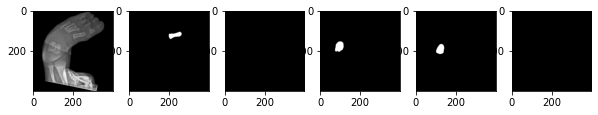

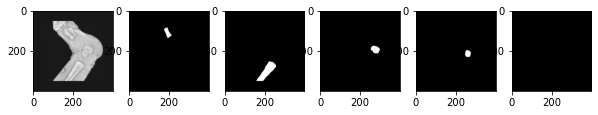

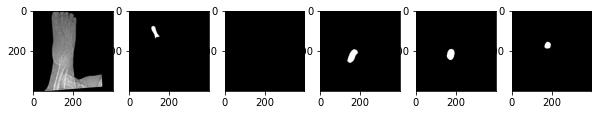

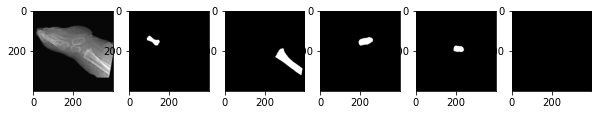

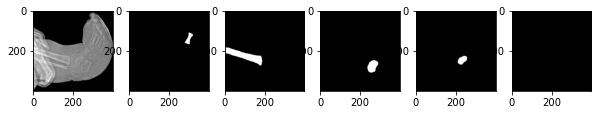

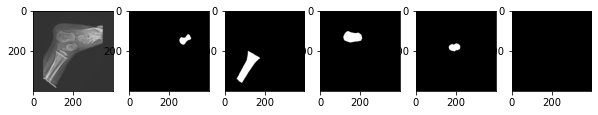

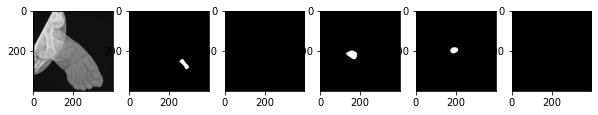

In [11]:
# Helper function to show a batch
def show_image_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['mask']
    batch_size = len(images_batch)
    for i in range(batch_size):
        image = sample_batched['image'][i,:,:]
        mask = sample_batched['mask'][i,:,:]
        f, axarr = plt.subplots(1,6, figsize = (10,10)) 
        axarr[0].imshow(image[0,].cpu(), cmap='gray') # [0,]
        axarr[1].imshow(mask[0,].cpu(), cmap='gray')
        axarr[2].imshow(mask[1,].cpu(), cmap='gray')
        axarr[3].imshow(mask[2,].cpu(), cmap='gray')
        axarr[4].imshow(mask[3,].cpu(), cmap='gray')
        axarr[5].imshow(mask[4,].cpu(), cmap='gray')
        

for i_batch, sample_batched in enumerate(training_dataloader):
    print(i_batch, sample_batched['image'].size(),sample_batched['mask'].size())    
    if i_batch == 0:
        show_image_batch(sample_batched)
        break

#  Load the Deep Learning Model

In [12]:
#summary(model, input_size=(1, 272, 256), device = device.type) # device.type) 
# Trainable params: 6,041,188
#import segmentation_models_pytorch as smp

#model = smp.Unet(
    #encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    #encoder_weights="imagenet",     # use `imagenet` pretrained weights for encoder initialization
    #in_channels = 1,  # model input channels (1 for grayscale images, 3 for RGB, etc.)
#    classes = 4,
    #activation = 'sigmoid',
    #aux_params=aux_params
#)

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = model.to(device)

In [13]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, n_classes = 5, 
             padding=True, up_mode='upsample').to(device)

x = torch.randn(1,1,320, 320).to(device)
print(model(x).shape, torch.min(model(x)), torch.max(model(x)))

torch.Size([1, 5, 320, 320]) tensor(0.4655, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5366, device='cuda:0', grad_fn=<MaxBackward1>)


/home/pattondm/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


class segmentation_models_pytorch.Unet(encoder_name: str = 'resnet34', encoder_depth: int = 5, encoder_weights: str = 'imagenet', decoder_use_batchnorm: bool = True, decoder_channels: List[int] = (256, 128, 64, 32, 16), decoder_attention_type: Optional[str] = None, in_channels: int = 3, classes: int = 1, activation: Union[str, callable, None] = None, aux_params: Optional[dict] = None)

# Basic Visualization of the Input Data 

0 torch.Size([8, 1, 400, 400]) torch.Size([8, 5, 400, 400])
torch.Size([8, 5, 400, 400]) tensor(0.4711, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4711, device='cuda:0', grad_fn=<MinBackward1>)


<Figure size 432x288 with 0 Axes>

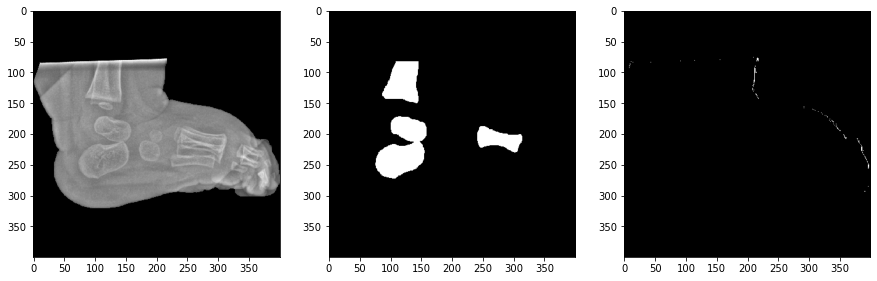

In [14]:
for i_batch, sample_batched in enumerate(training_dataloader):
    print(i_batch, sample_batched['image'].size(),sample_batched['mask'].size())
    if i_batch == 0:
        mask = model(sample_batched['image'].to(device))
        print(mask.size(), torch.min(mask), torch.min(mask))
        plt.figure()
        show_single_image_model(sample_batched, torch.round(mask))
        break

In [15]:
criterion = DC_loss2()
criterion2 = BCELoss()
parameters = model.parameters()
optimizer = optim.Adam(parameters, lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 250], gamma=0.1, last_epoch=-1)

In [16]:
for i_batch, sample_batched in enumerate(training_dataloader):
    print(i_batch, sample_batched['image'].size(),sample_batched['mask'].size())
    if i_batch == 0:
        inputs = sample_batched['image']
        targets = sample_batched['mask']
    
        inputs, targets = inputs.to(device), targets.to(device)
        print(inputs.shape, targets.shape)
        outputs = model(inputs) # s, label
        #print(inputs.shape, targets.shape, outputs.shape)
        break 

print(inputs.shape, targets.shape, outputs.shape)

0 torch.Size([8, 1, 400, 400]) torch.Size([8, 5, 400, 400])
torch.Size([8, 1, 400, 400]) torch.Size([8, 5, 400, 400])
torch.Size([8, 1, 400, 400]) torch.Size([8, 5, 400, 400]) torch.Size([8, 5, 400, 400])


In [17]:
d = criterion(outputs, targets.float()) # .repeat(1,3, 1, 1)
b = criterion2(outputs, targets.float()) # .repeat(1,3, 1, 1)
loss = 1 - torch.log(d) + b

In [18]:
print(os.getcwd())

/home/pattondm/Documents/ClubfootProjectData


In [19]:
base = os.getcwd()

In [20]:
def save_checkpoint(model, optimizer, train_epoch_metrics, val_epoch_metrics, epoch, is_best, logpath):
    logpath = logpath + '_unet_test1'
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_epoch_metrics': train_epoch_metrics,
        'val_epoch_metrics': val_epoch_metrics}

    filename = "{}.pth.tar".format(logpath)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, '{}.best.pth.tar'.format(logpath))

In [21]:
from tqdm import tqdm_notebook as tqdm
#from tqdm import notebook.tqdm # as tqdm

def run_epoch(mode, loader, net, criterion, criterion2, optimizer, alpha=0.99):
    if mode == 'train':
        net.train()
    else:
        net.eval()
    total_loss = 0
    total_dice = 0
    total_bce = 0
    for i, data in tqdm(enumerate(loader), total=len(loader)):
        inputs = data['image']
        targets = data['mask']

        inputs, targets = inputs.to(device), targets.to(device)

        with torch.set_grad_enabled(mode == 'train'):
            outputs = net(inputs) # outputs, labels
            d = criterion(outputs, targets.float())
            b = criterion2(outputs, targets.float())
            loss = 1 - torch.log(d) + b

            total_loss += loss.item()
            total_dice += d.item()
            total_bce += b.item()

            if mode == 'train':
                optimizer.zero_grad()

                loss.backward()
                optimizer.step()

    print('finished epoch', epoch, '{} mode'.format(mode), 'loss', total_loss / (i + 1))

    return {'loss': total_loss / (i + 1), 'dice': total_dice / (i + 1), 'bce': total_bce / (i + 1)}

In [22]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion.to(device)
criterion2.to(device)

model.to(device)

train_epoch_metrics = {
        'loss': [],
        'dice': [],
        'bce': []
    }
val_epoch_metrics = {
        'loss': [],
        'dice': [],
        'bce': []
    }

is_best = False
best_loss = 0

for epoch in range(10):
    train_metrics = run_epoch('train', training_dataloader, model, criterion, criterion2, optimizer)
    valid_metrics = run_epoch('test', validation_dataloader, model, criterion, criterion2, optimizer)
    
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(valid_metrics['loss'])
    else:
        scheduler.step()
    
    for m in valid_metrics:
        train_epoch_metrics[m].append(train_metrics[m])
        val_epoch_metrics[m].append(valid_metrics[m])
    
    if epoch == 0 or valid_metrics['loss'] < best_loss:
        is_best = True
        best_loss = valid_metrics['loss']
        
    save_checkpoint(model, optimizer, train_epoch_metrics, 
                    val_epoch_metrics, epoch, is_best, base)
    
    is_best = False

print('Finished Training')

<ipython-input-21-55a06dedcaad>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm(enumerate(loader), total=len(loader)):


RuntimeError: CUDA out of memory. Tried to allocate 314.00 MiB (GPU 0; 15.90 GiB total capacity; 14.73 GiB already allocated; 61.75 MiB free; 15.05 GiB reserved in total by PyTorch)

In [ ]:
plt.rcParams['figure.figsize'] = 10, 10

In [ ]:
plt.plot([i for i in range(len(train_epoch_metrics['loss']))], train_epoch_metrics['loss'], label='loss')
plt.plot([i for i in range(len(train_epoch_metrics['dice']))], train_epoch_metrics['dice'], label='dice')
plt.plot([i for i in range(len(train_epoch_metrics['bce']))], train_epoch_metrics['bce'], label='bce')

plt.title('Train metrics')
plt.legend();

In [ ]:
plt.plot([i for i in range(len(val_epoch_metrics['loss']))], val_epoch_metrics['loss'], label='loss')
plt.plot([i for i in range(len(val_epoch_metrics['dice']))], val_epoch_metrics['dice'], label='dice')
plt.plot([i for i in range(len(val_epoch_metrics['bce']))], val_epoch_metrics['bce'], label='bce')

plt.title('Validation metrics')
plt.legend()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, n_classes = 5, 
             padding=True, up_mode='upsample').to(device)

x = torch.randn(1,1,256, 256).to(device)
print(model(x).shape, torch.min(model(x)), torch.max(model(x)))
model.eval();

In [ ]:
os.chdir(base)
base_2 = '/home/pattondm/Documents'
optimizer_ = optim.Adam(model.parameters())
checkpoint = torch.load(os.path.join(base_2, 
                                     'ClubfootProjectData_unet_test1.best.pth.tar'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer_.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [ ]:
print('The best model training paramters was found on epoch # ', epoch)

In [ ]:
# Helper function to show a batch  
def show_image_batch_3(sample_batched, output):
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['mask']
    batch_size = len(images_batch)
    
    for i in range(batch_size):
        image = sample_batched['image'][i,:,:]
        mask = sample_batched['mask'][i,:,:]
        mask = torch.sum(mask, dim = 0)
        output_mask = output[i,:,:].cpu().detach()#.numpy()
        
        output_mask = torch.sum(output_mask, dim = 0)
        f, axarr = plt.subplots(1,3,figsize=(15,15)) 
        axarr[0].imshow(image[0,].cpu(), cmap='gray')
        axarr[1].imshow(mask.cpu(), cmap='gray')
        axarr[2].imshow(output_mask.cpu(), cmap='gray')
        

In [ ]:
validation_dataset = ClubfootDataset(df = validation_data,
                                     # mask = False
                                     bone = 'Multi',
                                     transform=transforms.Compose([toTensor(),
                                                                   LargeSizeCrop(256),
                                                                   combinedPad(),
                                                                   Normalize()]))

validation_dataloader = DataLoader(validation_dataset, batch_size=10,
                        shuffle=False, num_workers=0)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
model = model.to(device)
for i_batch, sample_batched in enumerate(validation_dataloader):
    print(i_batch, sample_batched['image'].size(),sample_batched['mask'].size())
    if i_batch == 0:
        mask = model(sample_batched['image'].to(device)) # , label
        #print(mask.shape, label.shape)
        plt.figure()
        show_image_batch_3(sample_batched, torch.round(mask))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#criterion.to(device)

model = model.to('cpu')#.to('cpu')
colnames = ['1st metarsel', 'tibia', 'calcaneus', 'talus', 'cuboid']
data = []
image_dice = []
for i_batch, sample_batched in enumerate(validation_dataloader):
    mask = model(sample_batched['image'].to('cpu'))#.to('cuda')#.to('cpu')) # , label
    mask =  torch.round(mask)
    
    for j in range(sample_batched['mask'].shape[0]):
        gt = sample_batched['mask'][j,]
        model_mask = mask[j,]
        
        data = []
        for i in range(sample_batched['mask'].shape[1]):
            gt_bone = gt[i,]
            model_mask_bone = model_mask[i,].to('cpu')
            data.append(dice_coef(model_mask_bone, gt_bone).item())
            
        image_dice.append([data])
        #print(image_dice)

In [ ]:
bone_dice = pd.DataFrame(image_dice, columns = ['Test']) 
bone_dice['Test']  = bone_dice['Test'].astype('str')
bone_dice['Test'] = bone_dice['Test'].str.strip('[]')
#bone_dice['Test'] = bone_dice['Test'].str.lstrip(']')
tmpDF = pd.DataFrame()
tmpDF = bone_dice['Test'].str.split(',',expand=True)
tmpDF.head()
tmpDF.columns=colnames
tmpDF.tail()

In [ ]:
tmpDF['1st metarsel'] = tmpDF['1st metarsel'].astype(float)
tmpDF['tibia'] = tmpDF['tibia'].astype(float)
tmpDF['calcaneus'] = tmpDF['calcaneus'].astype(float)
tmpDF['talus'] = tmpDF['talus'].astype(float)
tmpDF['cuboid'] = tmpDF['cuboid'].astype(float)

In [ ]:
tmpDF.describe().round(3)

In [ ]:
tmpDF.to_csv('Unet_test.csv')

In [ ]:
######################################################################################

In [ ]:
# Simple function to calculate the dice coeffificent by an individual image in batch
def dice_by_image(sample_batched, output, data, i_batch):
    for j in range(sample_batched['mask'].shape[0]):
        gt = sample_batched['mask'][j,]
        model_mask = output[j,]
        
        for i in range(sample_batched['mask'].shape[1]):
            gt_bone = gt[i,]
            model_mask_bone = model_mask[i,]
            data.append([dice_coef(model_mask_bone, gt_bone).item(), i_batch, j])
         
    return data

In [ ]:
# Random Grid Search
epochs = 100
base_dir = 'C:\\Users\\danie\\OneDrive\\Documents\\Clubfoot\\GroundTruthSegmentation\\Final_Seg_Maps_NIFTI2\\Models'

i = 0
while i < 10:
    i += 1
    # Hyperparamters being tuned
    batch_group = [4, 8, 12, 16]
    lr_group = [1e-2, 0.005, 1e-3]
    criteria_group = [DC_loss2(), BCELoss(), 'Combined']
    augmentations_group = ['Clahe_Aug', 'Aug', 'No_Aug']
    model_num_group = [2, 3]
    
    # Random Selection
    batch = random.choice(batch_group)
    lr = random.choice(lr_group)
    criterionn = random.choice(criteria_group)
    augments = random.choice(augmentations_group)
    model_num = random.choice(model_num_group)
    
    # Defining parameters based upon criterion
    criterion, criterion2, transformations, model = return_criterions(criterionn, augments, model_num) 
        
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)

    logpath = 'batch'+ str(batch) + '_lr' + str(lr) + '_augs' + str(augments) + '_model' + str(model_num) +'_Criterions' + str(criterionn) #str(criterion)[:-3] + '_' + str(criterion2)[:-2]        
    print(batch, lr, criterionn, augments, model_num, '\n')
    print(logpath)

    #################################################################################
    # Training Loop
    #################################################################################
    # Load the data
    validation_dataset = BoneBackground(df = validation_data,
                                         transform=transforms.Compose(transformations)
                                       )
    validation_dataloader = DataLoader(validation_dataset, batch_size = batch,
                            shuffle=False, num_workers=0)

    training_dataset = BoneBackground(df = training_data,
                                        transform=transforms.Compose(transformations)
                                      )
    training_dataloader = DataLoader(training_dataset, batch_size = batch,
                            shuffle=True, num_workers=0)

    # Creating a dictionary of paramters to simplify visualization
    params={
     "num_epochs": epochs, 
        "optimizer": optimizer,
     "criterion": criterion,
     "criterion2": criterion2,
     "train_dl": training_dataloader,
     "val_dl": validation_dataloader,
     "lr_scheduler": scheduler,
        "log_path": logpath,
    "base_dir": base_dir}

    # Training the model
    train_epoch_metrics, val_epoch_metrics = model_training(model, params)

    # Save loss function training and validation plots
    save_images(train_epoch_metrics, train_epoch_metrics, base_dir, logpath)

    # Reloading the Model with the Best Parameters
    if model_num == 2:
        model = FCNmodel_2pool(n_class=1)
    else:
        model = FCNmodel_3pool(n_class=1)

    optimizer_ = optim.Adam(model.parameters())
    checkpoint = torch.load(os.path.join(base_dir, logpath + '.best.pth.tar'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer_.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to('cpu')

    # Saving example images of the model output
    for i_batch, sample_batched in enumerate(validation_dataloader):
        print(i_batch, sample_batched['image'].size(),sample_batched['mask'].size())
        if i_batch == 0:
            mask = model(sample_batched['image'].to('cpu'))
            plt.figure()
            save_image_batch_model(sample_batched, torch.round(mask), base_dir, logpath)
            break      


    # Create the pandas DataFrame of Dice coefficients on a slice by slice basis for validation data
    mask_name = ['background', 'batch_num', 'j']
    data = []

    for i_batch, sample_batched in enumerate(validation_dataloader):
        mask = model(sample_batched['image'])
        data = dice_by_image(sample_batched, torch.round(mask), data, i_batch)

    dice_df = pd.DataFrame(data, columns = ['dice', 'batch', 'batch_num']) 
    dice_df.to_csv(logpath + '.csv')